# ZERNIKE MOMENTS (shape descriptors)
- Unlike Hu Moments, Zernike Moments are more powerful and generally more accurate image descriptors with very little additional computational cost.
- The reason Zernike moments tend to be more powerful is because they are orthogonal — this means that there is little-to-no redundancy of information between the moments.
- Before zernike moments were published, Hu Moments were primarily used as shape descriptors.

## What are they used to describe?
- Used to characterize the shape of an object in an image.

## How do they work?
- Using orthogonal functions. 
- The benefit of orthogonal functions is that there is no redundancy of information between moments, making them more robust and discriminative than Hu Moments, which are based on simple statistical derivations.
- Zernike polynomials are orthonal over a disk with radius r. The circle should technically be set properly to include the entire region of the shape.
- Pixels that fall outside the disc are igonored and not included in the computation.
- From there, Zernike Moments up to degree d are computed and utilized as the feature vector. The size of the returned feature vector is directly controlled by the degree of the polynomial. The larger the degree, the larger the feature vector.
- Check [link](http://www.csie.ntnu.edu.tw/~bbailey/Moments%20in%20IP.htm) for math info
- Implemented in mahotas Python package. 

## Exercise
- Below coding example, we are going to recognize a single object among group of objects in an image, using another reference image which contains the object to be recognized

In [1]:
import sys
sys.path.append("../")

In [2]:
from scipy.spatial import distance as dist
import numpy as np
import mahotas
import cv2
import imutils
from cv_imshow import display_image, create_subplot

In [6]:
args = {
    "refImage": "../images/pokemon_red.png",
    "image": "../images/shapes.png"
}

- We don't directly get roi by using boundingRect for a contour in this because it would overlap with another object.
- So, we drawContour on separate mask of shape=image.shape and then get boundingRect to fetch ROI 

In [5]:
def describe_shapes(image):
    #initialize list of shape features
    shapeFeatures = []
    
    #convert image to grayscale, blur and thresh it
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (13,13),0)
    thresh = cv2.threshold(blurred, 50, 255, cv2.THRESH_BINARY)[1]
    
    #perform series of dilations and erosions to close holes in shapes
    thresh = cv2.dilate(thresh, None, iterations=4)
    thresh = cv2.erode(thresh, None, iterations=2)
    
    #detect contours
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    
    #loop over the contours
    for c in cnts:
        #create an empty mask for the contour and draw it
        mask = np.zeros(image.shape[:2], dtype="uint8")
        cv2.drawContours(mask, [c], -1, 255, -1)
        
        #extract bouding box ROI from mask
        (x,y,w,h) = cv2.boundingRect(c)
        roi = mask[y:y+h, x:x+w]
        
        #compute zernike moments for roi
        features = mahotas.features.zernike_moments(roi, cv2.minEnclosingCircle(c)[1], degree=8)
        shapeFeatures.append(features)
    return (cnts, shapeFeatures)

In [8]:
#load the reference image containing the object we want to detect then desribe the game region
refImage = cv2.imread(args["refImage"])
(_, gameFeatures) = describe_shapes(refImage)

#load the shapes image and describe zernike moments features
shapesImage = cv2.imread(args["image"])
(cnts, shapeFeatures) = describe_shapes(shapesImage)

#compute euclidean dist between the game features and each of the shapes
#find index with smallest distance.
d = dist.cdist(gameFeatures, shapeFeatures)
i = np.argmin(d)

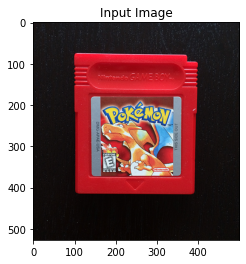

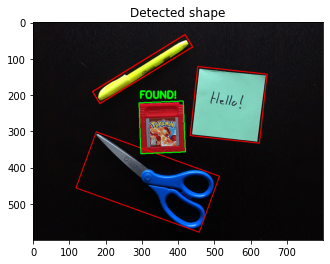

In [12]:
#loop over the contours
for (j,c) in enumerate(cnts):
    if i!=j:
        box = cv2.minAreaRect(c)
        box = np.int0(cv2.boxPoints(box))
        cv2.drawContours(shapesImage, [box], -1, (0,0,255), 2)

#draw the boudning box around the detectedd shape
box = cv2.minAreaRect(cnts[i])
box = np.int0(cv2.boxPoints(box))
cv2.drawContours(shapesImage, [box], -1, (0,255,0),2)
(x,y,w,h) = cv2.boundingRect(cnts[i])
cv2.putText(shapesImage, "FOUND!", (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9,
           (0,255,0), 3)

display_image("Input Image", refImage)
display_image("Detected shape", shapesImage)

## Suggestions whe using zernike moments
- If you need to describe multiple shapes in an image, be sure to extract the ROI of each object, and then extract Zernike Moments from each ROI.
- The degree parameter directly affects the dimensionality of your resulting feature vector. 

## Pros
- Very fast to compute.
- Low dimensional.
- Very good at describing simple shapes.
- Fairly simple to tune the radius  and degree  parameters.

## Cons
- Requires a very precise segmentation of the object to be described.
- Normally only used for simple 2D shape segmentation — as shapes become more complex, Zernike Moments often do not perform well.
- Just like Hu Moments, Zernike Moments are calculated based on the initial centroid computation — if this centroid is not repeatable for similar shapes, the Zernike Moments will not obtain good matching accuracy.